## Imports

In [1]:
!pip install protpy
!pip install biopython

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import explained_variance_score,max_error,mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, ShuffleSplit, KFold
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle
import protpy as protpy

## Trainer class

In [3]:
# Define hyperparameter distributions for RandomizedSearchCV
Lasso_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "fit_intercept": [True, False],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10]
}

Ridge_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "fit_intercept": [True, False],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10],
    "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

DT_params = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

RF_params = {
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 3, 4],
    "min_samples_leaf": [1, 2, 3, 4, 5, 6],
    "max_features": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

EN_params = {
    "alpha": [0.1, 0.5, 1, 5, 10, 50, 100],
    "l1_ratio": [0, 0.2, 0.4, 0.6, 0.8, 1],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10, 15]
}

SVR_params = {
    "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
    "degree": [2, 3, 4],
    "tol": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 10],
    "gamma": ['scale', 'auto'],
    "coef0": [0, 2, 4]
}

def get_scoring_function(scoring):
    if scoring == 'explained_variance':
        return explained_variance_score
    elif scoring == 'max_error':
        return max_error
    elif scoring == 'neg_mean_absolute_error':
        return lambda y_true, y_pred: -mean_absolute_error(y_true, y_pred)
    elif scoring == 'neg_mean_squared_error':
        return lambda y_true, y_pred: -mean_squared_error(y_true, y_pred)
    elif scoring == 'neg_mean_squared_log_error':
        return lambda y_true, y_pred: -mean_squared_log_error(y_true, y_pred)
    elif scoring == 'r2':
        return r2_score
    else:
        raise ValueError(f"Scoring method '{scoring}' is not recognized. Available methods are: ['explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'r2']")


class MLModelTrainer:
    def __init__(self, model_name, n_iter=10, cv=5, scoring='r2', warm_start=False, group_by_gene = True):
        self.model_name = model_name
        self.n_iter = n_iter
        self.cv = cv
        self.scoring = scoring
        self.group_by_gene=group_by_gene
        
        # Initialize model based on the specified model_name
        self.model, self.param_distributions = self._initialize_model(warm_start)
        
        
            

    def _initialize_model(self, warm_start):
        models = {
            'lasso': Lasso(warm_start=warm_start),
            'ridge': Ridge(),
            'decision_tree': DecisionTreeRegressor(),
            'random_forest': RandomForestRegressor(warm_start=warm_start),
            'elastic_net': ElasticNet(warm_start=warm_start),
            'svr': SVR()
        }
        
        params = {
            'lasso': Lasso_params,
            'ridge': Ridge_params,
            'decision_tree': DT_params,
            'random_forest': RF_params,
            'elastic_net': EN_params,
            'svr': SVR_params
        }
        
        if self.model_name not in models:
            raise ValueError(f"Model '{self.model_name}' is not supported.")
        
        return models[self.model_name], params[self.model_name]
    
    def fit(self, X, y):
        # Create a pipeline with standard scaling and the specified model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            ('model', self.model)
        ])

        if self.param_distributions:
            # Perform RandomizedSearchCV for hyperparameter tuning
            random_search = RandomizedSearchCV(
                pipeline['model'], 
                param_distributions=self.param_distributions,
                n_iter=self.n_iter, 
                cv=self.cv, 
                scoring=self.scoring,
                random_state=42, 
                n_jobs=-1
            )
            random_search.fit(X, y)
            self.best_model = random_search.best_estimator_
            self.best_params = random_search.best_params_
        else:
            # Fit the pipeline without hyperparameter tuning
            self.best_model = pipeline.fit(X, y)
            self.best_params = None

        
    def cross_validation(self, X, y, input_value=None):
        self.X = X.copy()
        self.y = y.copy().values.ravel()

        NUM_TRIALS = input_value if input_value else self.n_iter

        '''if 'Group' in X.columns:
            X.drop(columns=['Group'], inplace=True)

        # Create the group column for grouping
        X['Group'] = X.groupby(list(set(X.columns) - set(['Transcripts']))).ngroup()'''

        if(self.group_by_gene):
            self.G=self.X['Gene']
            
        else:
            self.G=self.X.index
            
        self.X.drop("Gene", inplace=True, axis=1)
        
        self.features = self.X.columns
        self.itr_number = []
        self.outer_results = []
        self.inner_results = []
        self.model_params = []
        self.G_test_list = []
        self.y_test_list = []
        self.pred_list = []

        for i in range(NUM_TRIALS):
            cv_outer = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=i)

            for train_index, test_index in cv_outer.split(self.X, self.y, self.G):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y[train_index], self.y[test_index]
                G_train, G_test = self.G[train_index], self.G[test_index]

                model_to_use = self.best_model if hasattr(self, 'best_model') else self.model

                G_test = np.array(G_test)
                self.G_test_list.append(G_test)
                y_test = np.array(y_test)
                self.y_test_list.append(y_test)

                cv_inner = GroupKFold(n_splits=10)
                search = RandomizedSearchCV(
                    estimator=model_to_use,
                    param_distributions=self.param_distributions,
                    n_iter=100,
                    verbose=0,
                    scoring=self.scoring,
                    cv=cv_inner,
                    n_jobs=6,
                    refit=True
                )

                result = search.fit(X_train, y_train, groups=G_train)
                best_model = result.best_estimator_
                best_score = abs(result.best_score_)
                self.inner_results.append(best_score)

                yhat = best_model.predict(X_test)
                self.pred_list.append(yhat)

                scoring_func = get_scoring_function(self.scoring)
                acc = scoring_func(y_test, yhat)

                self.itr_number.append(i + 1)
                self.outer_results.append(acc)
                self.model_params.append(result.best_params_)

                print('\n################################################################\n\nSTATUS REPORT:')
                print(f'Iteration {i + 1} of {NUM_TRIALS} runs completed')
                print(f'Test_Score: {acc:.3f}, Best_Valid_Score: {best_score:.3f}\n\nBest_Model_Params:\n{result.best_params_}')
                print("\n################################################################\n ")

                plt.figure(figsize=(10, 6))
                plt.scatter(y_test, yhat, c=X_test["Transcripts"], cmap='cool', edgecolor='k', alpha=0.5, edgecolors='face')
                plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
                plt.xlabel('True Values')
                plt.ylabel('Predictions')
                plt.title('Prediction vs True Values')
                plt.colorbar()
                plt.grid(True)
                plt.show()

          
    def find_best_model(self):
        # assign the best model paramaters
        best_model_params = self.CV_dataset.iloc[0,3]
        # set params from the best model to a class object
        best_model = self.model.set_params(**best_model_params)
        self.best_model = best_model.fit(self.X, self.y)
        self.y_pred=self.best_model.predict(self.X)
    
    def results(self):   
        #create dataframe with results of nested CV
        list_of_tuples = list(zip(self.itr_number, self.inner_results, self.outer_results, self.model_params, self.G_test_list, self.y_test_list, self.pred_list))
        CV_dataset = pd.DataFrame(list_of_tuples, columns = ['Iter', 'Valid Score', 'Test Score', 'Model Parms', 'Genes', 'True Abundance', 'Predicted Abundance'])
        CV_dataset['Score_difference'] = abs(CV_dataset['Valid Score'] - CV_dataset['Test Score']) #Groupby dataframe model iterations that best fit the data (i.e., validitaion <= test)
        CV_dataset.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True) 
        CV_dataset = CV_dataset.reset_index(drop=True) # Reset index of dataframe
        # save the results as a class object
        self.CV_dataset = CV_dataset
    
    def get_importances(self):
        if(self.model_name=='decision_tree' or self.model_name=='random_forest'):
            imp=pd.DataFrame([self.features,self.best_model.feature_importances_])
        elif(self.model_name=='lasso' or self.model_name=='ridge' or self.model_name=='elastic_net'):
            imp=pd.DataFrame([self.features,self.best_model.coef_])
        imp=imp.T
        imp.columns=["Feature", "Importance"]
        imp.sort_values(by="Importance", ascending=False, inplace=True)
        return imp.loc[imp["Importance"]>0].copy()
    
    def plot_predictions_vs_true(self, log=False):
        if not hasattr(self, 'y_test') or not hasattr(self, 'y_pred'):
            raise ValueError("Model must be fitted before plotting.")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.y_pred, c=self.X_test["Transcripts"], cmap='cool', edgecolor='k', alpha=0.5, edgecolors='face')
        plt.plot([min(self.y_test), max(self.y_test)], [min(self.y_test), max(self.y_test)], color='red', linestyle='--')
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('Prediction vs True Values')
        if(log==True):
            plt.xscale('log')
            plt.yscale('log')
        plt.colorbar()
        plt.grid(True)
        plt.show()
        
# Example usage:




## Import data

In [4]:
quantile="0.25"
X_raw=pd.read_excel("/kaggle/input/scrna-seq-quantile-regression-results/qRegResults_log.xlsx")
cols=list(X_raw.columns)
cols[0]="Gene"
X_raw.columns=cols
y_raw=X_raw[[quantile+"_slope", quantile+"_intercept"]]
X_raw=X_raw["Gene"]
display(X_raw)
display(y_raw)

0         CD22
1          CR1
2          CD7
3         CCR4
4         CD36
5        ITGAX
6         SELP
7        CD79B
8      CLEC12A
9        TIGIT
10       IL2RB
11        CD3D
12    TNFRSF18
13       NLRP2
14       CD163
15      ENTPD1
16      HAVCR2
17        CD28
18       ITGAL
19       CTLA4
20        CD38
21       CD274
22       NCAM1
23        CD14
24       FCER2
25       KLRB1
26       ICAM1
27      FCGR3A
28      ICOSLG
29      CX3CR1
30       PVRL2
31       KLRD1
32      LGALS3
33        CD8A
34       ITGB1
35       ITGA6
36      ITGA2B
37    TNFSF13B
38    TNFRSF17
39        CCR6
40       CD226
41        SELL
42       PTCRA
43       CXCR4
44        CD1D
45        CD83
46        CD69
47        IL7R
48       IL3RA
49       FCRL5
50     SIGLEC7
51      LILRB1
52       KLRG1
53       IL2RA
54      CLEC4C
55        TFRC
56     KIR2DL3
57        IL4R
58       PTPRC
59        LAG3
Name: Gene, dtype: object

,0.25_slope,0.25_intercept
0,1.904977e-01,5.551333e-02
1,3.476169e-01,1.452575e+00
2,4.850623e-01,3.868263e-01
3,5.268490e-02,6.991821e-01
4,4.215279e-01,1.434386e-01
5,3.703175e-01,8.105914e-01
6,8.467974e-02,1.099113e+00
7,1.294714e-01,1.159872e+00
8,7.062982e-01,9.392309e-01
9,3.832774e-02,1.800544e+00


## Remove genes with low variance

In [5]:
var_threshold=0

high_var_genes=[]
T_df=pd.read_excel("/kaggle/input/log-transformed-prot-vs-rna/Inter-cluster_points_log_imputated.xlsx")
for g in T_df["Gene"]:
    if((T_df.loc[T_df["Gene"]==g,"x_median"]>var_threshold).any()):
        high_var_genes.append(g)
        
high_var_genes=list(set(high_var_genes))
print(len(high_var_genes))

high_var_index=(X_raw.isin(high_var_genes))
X_raw=X_raw.loc[high_var_index]
y_raw=y_raw.loc[high_var_index]
X_raw.reset_index(inplace=True, drop=True)
y_raw.reset_index(inplace=True, drop=True)

148


## Data augmentation

In [6]:
gene_col=[]
transcripts_col=[]
proteins_col=[]

for j, idx in enumerate(X_raw.index):
    for i in range(10):
        gene_col.append(X_raw.loc[idx])
        transcripts_col.append(i)
        proteins_col.append(i*y_raw[quantile+"_slope"].values[j]+y_raw[quantile+"_intercept"].values[j])

X_aug=pd.DataFrame([gene_col, transcripts_col])
X_aug=X_aug.T
X_aug.columns=["Gene", "Transcripts"]
y_aug=pd.DataFrame({"Proteins":proteins_col})

In [7]:
X_aug

,Gene,Transcripts
0,CD22,0
1,CD22,1
2,CD22,2
3,CD22,3
4,CD22,4
...,...,...
585,LAG3,5
586,LAG3,6
587,LAG3,7
588,LAG3,8


## Choose descriptors

In [8]:
from Bio import SeqIO
def get_fasta(geneList):
    gene_to_seq = {}
    sequences=[]
    geneList=list(geneList)
    successfulGenes=[]

    for record in SeqIO.parse("/kaggle/input/uniprot-swissprot-fasta/uniprot_sprot.fasta", "fasta"):
        org=record.name.split("|")[2].split("_")[1]
        try:
            gene=record.description.split("GN=")[1].split(" ")[0]
        except:
            gene=record.name.split("|")[2].split("_")[0]
        if(org == "HUMAN" and gene in geneList):
            gene_to_seq[gene]=record.seq
            #print(gene_to_seq)
    for gene in geneList:
        try:
            new_seq=gene_to_seq[gene]
            sequences.append(new_seq)
            successfulGenes.append(gene)
        except:
            pass
    return sequences, successfulGenes

In [9]:
descriptors='DPComp' # AAComp, DPComp, CTriad, MBAuto

sequences, successfulGenes=get_fasta(X_aug["Gene"])
to_keep=X_aug['Gene'].isin(successfulGenes)
X = X_aug[to_keep]
y = y_aug[to_keep]
X.reset_index(inplace=True, drop=True)
y.reset_index(inplace=True, drop=True)

descList=[]
if(descriptors=='AAComp'):
    for seq in sequences:
        descList.append(protpy.amino_acid_composition(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='CTriad'):
    for seq in sequences:
        descList.append(protpy.conjoint_triad(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='DPComp'):
    for seq in sequences:
        descList.append(protpy.dipeptide_composition(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))
elif(descriptors=='MBAuto'):
    for seq in sequences:
        descList.append(protpy.moreaubroto_autocorrelation(str(seq)))
    desc_df=pd.DataFrame(np.squeeze(descList))

#desc_df.reset_index(inplace=True, drop=True)

X=pd.concat([X, desc_df], axis=1)
X.columns = X.columns.astype(str)

display(X)

,Gene,Transcripts,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
0,CD22,0,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.00,0.12,0.59,0.47,0.12,0.12,0.12
1,CD22,1,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.00,0.12,0.59,0.47,0.12,0.12,0.12
2,CD22,2,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.00,0.12,0.59,0.47,0.12,0.12,0.12
3,CD22,3,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.00,0.12,0.59,0.47,0.12,0.12,0.12
4,CD22,4,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.00,0.12,0.59,0.47,0.12,0.12,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,LAG3,5,0.76,0.00,0.19,0.38,0.19,1.34,0.0,0.19,...,0.0,0.19,0.00,0.19,0.38,0.00,0.38,0.00,0.00,0.00
576,LAG3,6,0.76,0.00,0.19,0.38,0.19,1.34,0.0,0.19,...,0.0,0.19,0.00,0.19,0.38,0.00,0.38,0.00,0.00,0.00
577,LAG3,7,0.76,0.00,0.19,0.38,0.19,1.34,0.0,0.19,...,0.0,0.19,0.00,0.19,0.38,0.00,0.38,0.00,0.00,0.00
578,LAG3,8,0.76,0.00,0.19,0.38,0.19,1.34,0.0,0.19,...,0.0,0.19,0.00,0.19,0.38,0.00,0.38,0.00,0.00,0.00


## Multiply all descriptors by the number of transcripts (per row)

In [10]:
import pandas as pd

X_mul = X[['Gene','Transcripts']].copy()

# Multiply each descriptor column by the "Transcripts" column
for column in X.columns[2:]:
    X_mul[column] = X['Transcripts'] * X[column]

X=X_mul
display(X)

/tmp/ipykernel_109/1103020376.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mul[column] = X['Transcripts'] * X[column]
/tmp/ipykernel_109/1103020376.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_mul[column] = X['Transcripts'] * X[column]
/tmp/ipykernel_109/1103020376.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented fram

,Gene,Transcripts,0,1,2,3,4,5,6,7,...,390,391,392,393,394,395,396,397,398,399
0,CD22,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CD22,1,0.24,0.35,0.12,0.35,0.12,0.24,0.0,0.35,...,0.0,0.35,0.24,0.0,0.12,0.59,0.47,0.12,0.12,0.12
2,CD22,2,0.48,0.7,0.24,0.7,0.24,0.48,0.0,0.7,...,0.0,0.7,0.48,0.0,0.24,1.18,0.94,0.24,0.24,0.24
3,CD22,3,0.72,1.05,0.36,1.05,0.36,0.72,0.0,1.05,...,0.0,1.05,0.72,0.0,0.36,1.77,1.41,0.36,0.36,0.36
4,CD22,4,0.96,1.4,0.48,1.4,0.48,0.96,0.0,1.4,...,0.0,1.4,0.96,0.0,0.48,2.36,1.88,0.48,0.48,0.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,LAG3,5,3.8,0.0,0.95,1.9,0.95,6.7,0.0,0.95,...,0.0,0.95,0.0,0.95,1.9,0.0,1.9,0.0,0.0,0.0
576,LAG3,6,4.56,0.0,1.14,2.28,1.14,8.04,0.0,1.14,...,0.0,1.14,0.0,1.14,2.28,0.0,2.28,0.0,0.0,0.0
577,LAG3,7,5.32,0.0,1.33,2.66,1.33,9.38,0.0,1.33,...,0.0,1.33,0.0,1.33,2.66,0.0,2.66,0.0,0.0,0.0
578,LAG3,8,6.08,0.0,1.52,3.04,1.52,10.72,0.0,1.52,...,0.0,1.52,0.0,1.52,3.04,0.0,3.04,0.0,0.0,0.0


In [11]:
'''#best_models[0].predict
temp_df=pd.concat([X, y], axis=1).sort_values(by="Transcripts", ascending=True)
display(temp_df)
temp_df=temp_df.loc[X["Gene"]=="KLRD1"].copy()
y_true=temp_df["y_"+quant_func]
temp_df.drop(["Gene", "y_"+quant_func], inplace=True, axis=1)
y_pred=best_models[2].predict(temp_df)

plt.scatter(temp_df["Transcripts"], y_true)
plt.plot(temp_df["Transcripts"], y_pred, 'r')
plt.show()'''

'#best_models[0].predict\ntemp_df=pd.concat([X, y], axis=1).sort_values(by="Transcripts", ascending=True)\ndisplay(temp_df)\ntemp_df=temp_df.loc[X["Gene"]=="KLRD1"].copy()\ny_true=temp_df["y_"+quant_func]\ntemp_df.drop(["Gene", "y_"+quant_func], inplace=True, axis=1)\ny_pred=best_models[2].predict(temp_df)\n\nplt.scatter(temp_df["Transcripts"], y_true)\nplt.plot(temp_df["Transcripts"], y_pred, \'r\')\nplt.show()'

## Grouped


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: -0.006, Best_Valid_Score: 0.021

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 8, 'max_depth': 2}

################################################################
 


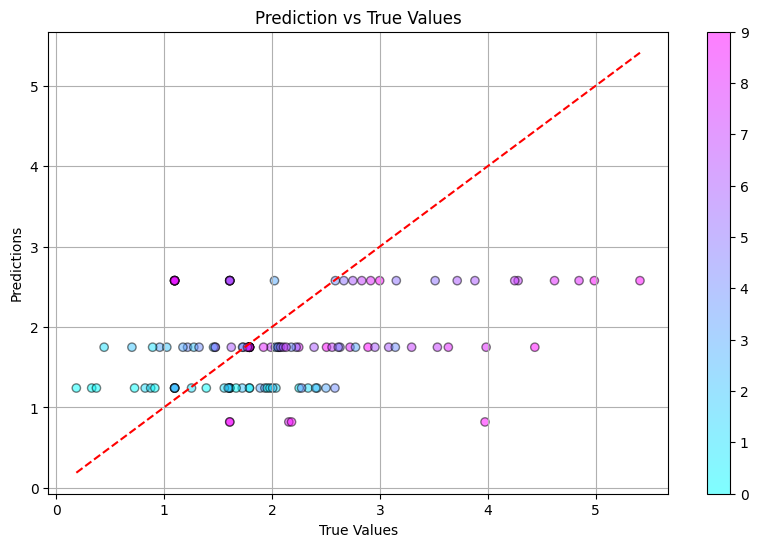


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: -0.704, Best_Valid_Score: 0.062

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 8, 'max_depth': 3}

################################################################
 


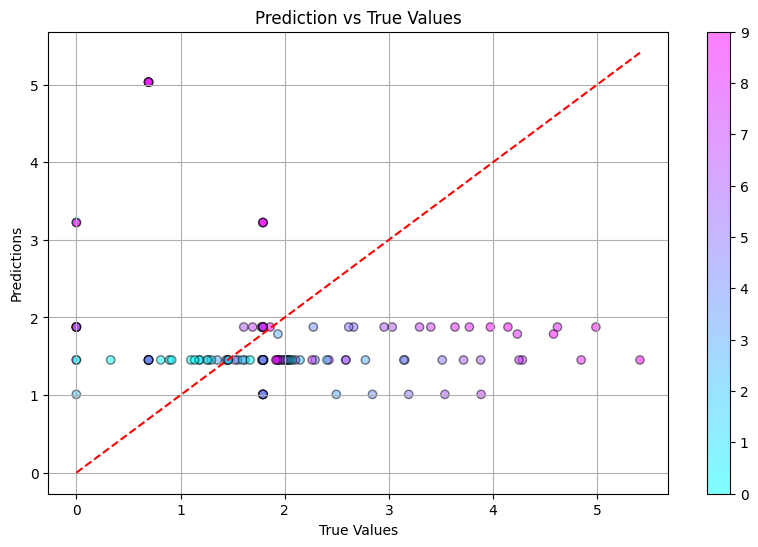


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: -0.043, Best_Valid_Score: 0.151

Best_Model_Params:
{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 2}

################################################################
 


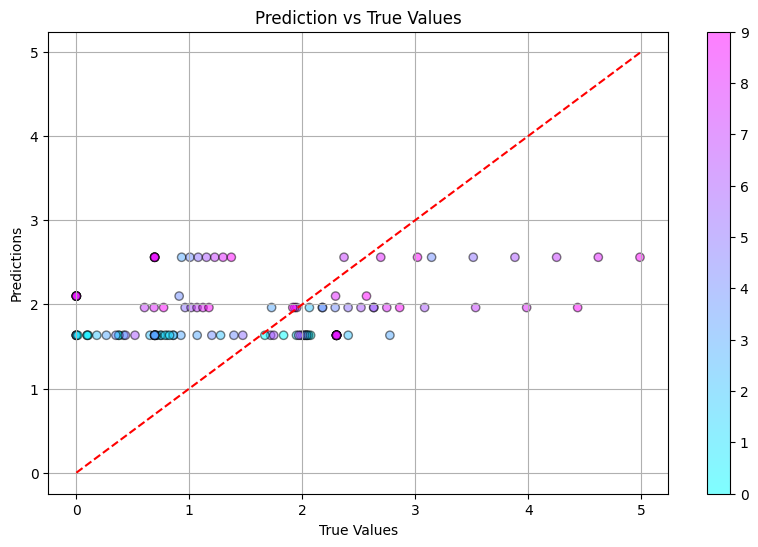


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: -0.178, Best_Valid_Score: 0.043

Best_Model_Params:
{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 2}

################################################################
 


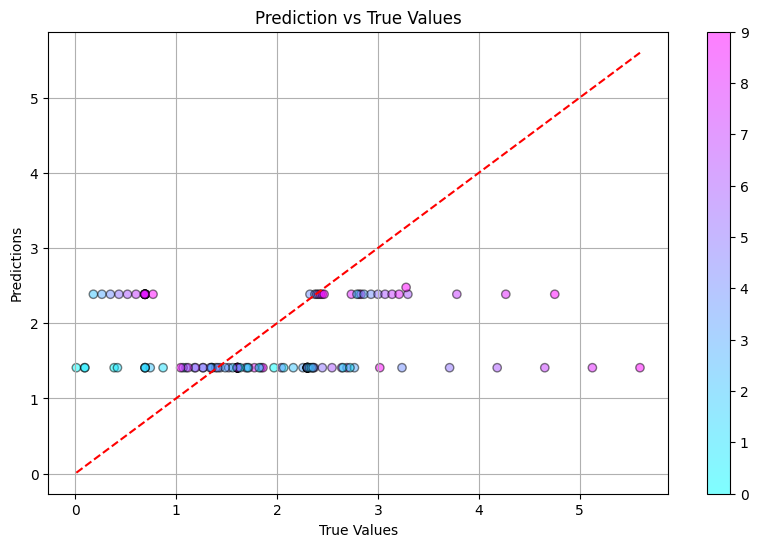


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.015, Best_Valid_Score: 0.123

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 3}

################################################################
 


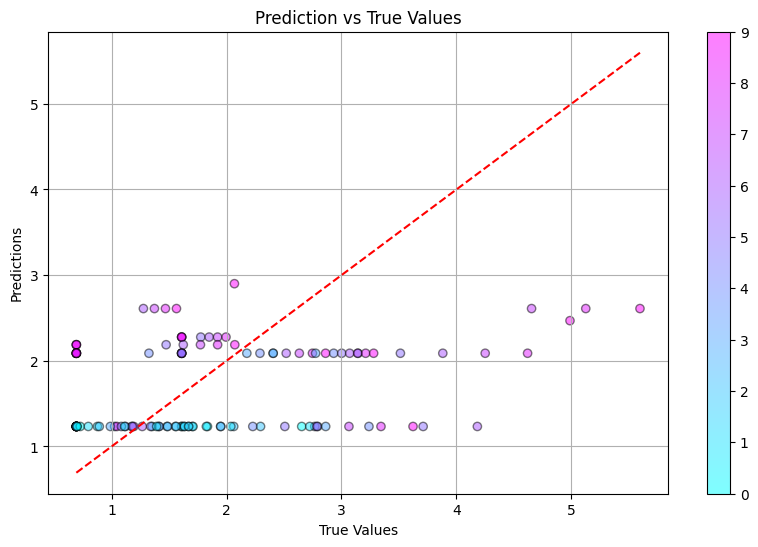

   Iter  Valid Score  Test Score  \
0     1     0.021031   -0.005500   
1     5     0.122954    0.014983   
2     3     0.150553   -0.043186   
3     4     0.043387   -0.178137   
4     2     0.061629   -0.704219   

                                         Model Parms  \
0  {'min_samples_split': 2, 'min_samples_leaf': 6...   
1  {'min_samples_split': 2, 'min_samples_leaf': 3...   
2  {'min_samples_split': 3, 'min_samples_leaf': 3...   
3  {'min_samples_split': 3, 'min_samples_leaf': 3...   
4  {'min_samples_split': 2, 'min_samples_leaf': 5...   

                                               Genes  \
0  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   
1  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   
2  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   
3  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   
4  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   

                                      True Abundance  \
0  [0.1875793150727274, 0.4451864182509482, 0.702... 

,Feature,Importance
129,128,0.556124
241,240,0.443876



################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: 0.011, Best_Valid_Score: 0.006

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 1, 'max_depth': 5}

################################################################
 


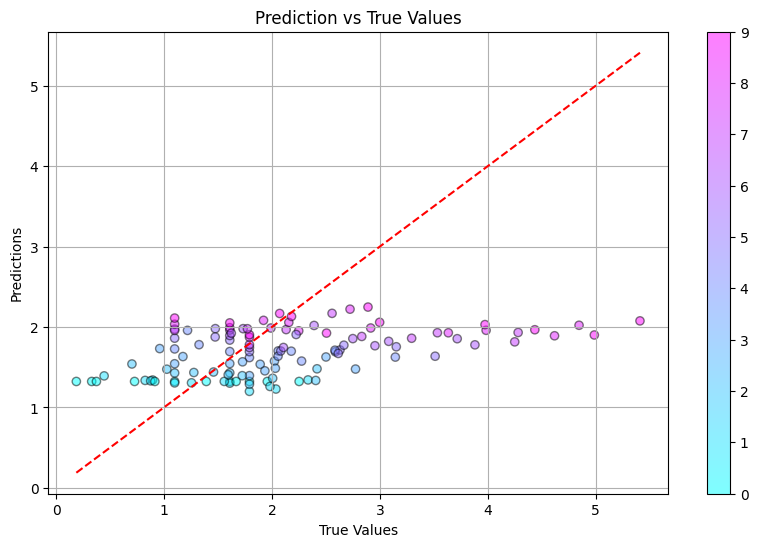


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.090, Best_Valid_Score: 0.033

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 6, 'max_depth': 5}

################################################################
 


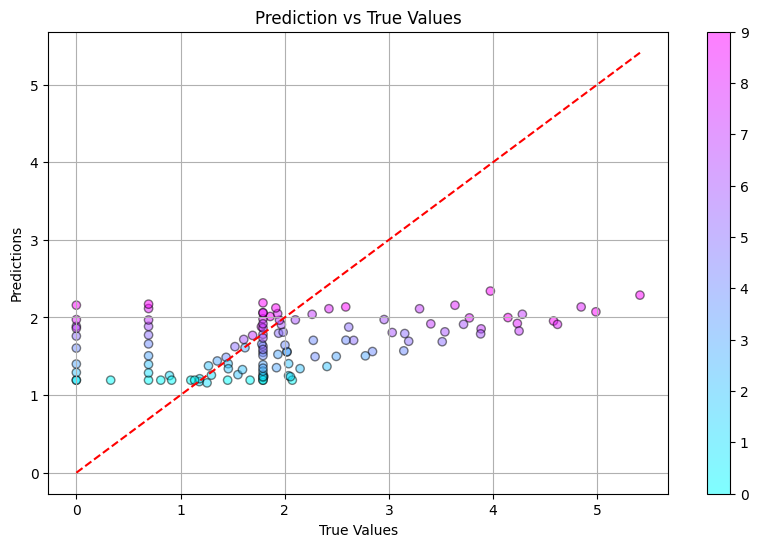


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: 0.035, Best_Valid_Score: 0.038

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 2, 'max_depth': 5}

################################################################
 


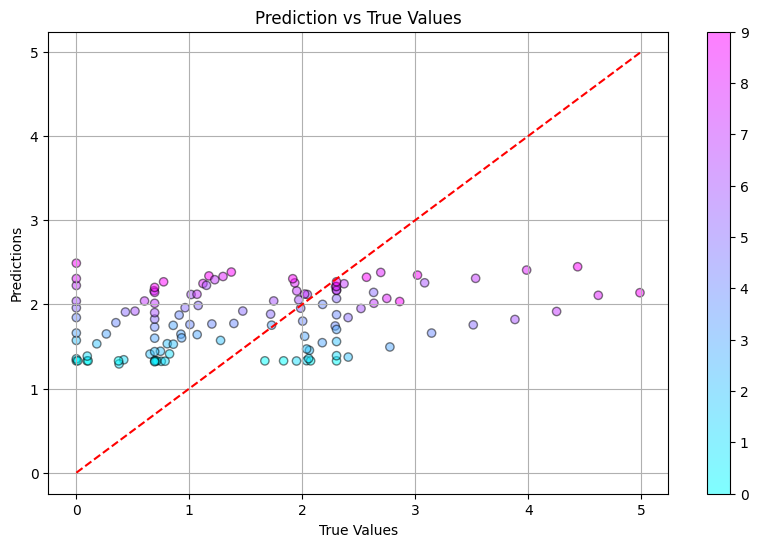


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.063, Best_Valid_Score: 0.130

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 9, 'max_depth': 3}

################################################################
 


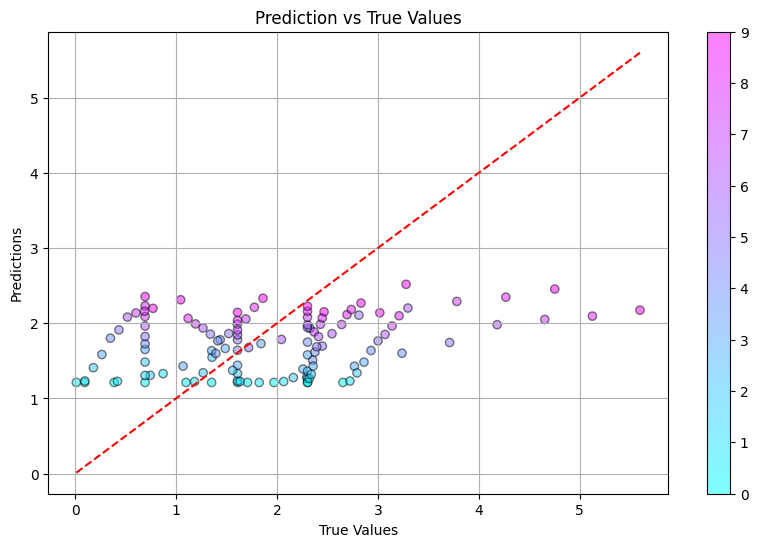


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.016, Best_Valid_Score: 0.009

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 2, 'max_depth': 3}

################################################################
 


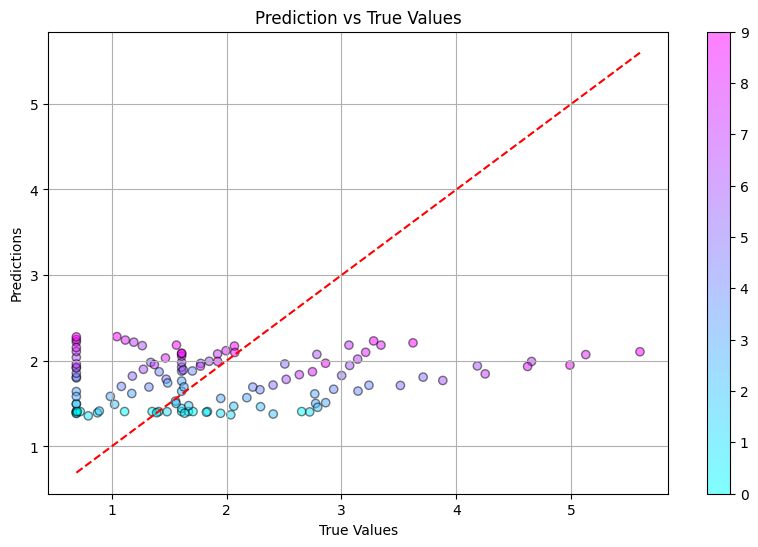

   Iter  Valid Score  Test Score  \
0     3     0.038415    0.034642   
1     1     0.005576    0.010578   
2     5     0.008782    0.016375   
3     2     0.033275    0.090498   
4     4     0.130340    0.062939   

                                         Model Parms  \
0  {'min_samples_split': 2, 'min_samples_leaf': 5...   
1  {'min_samples_split': 2, 'min_samples_leaf': 5...   
2  {'min_samples_split': 4, 'min_samples_leaf': 6...   
3  {'min_samples_split': 2, 'min_samples_leaf': 1...   
4  {'min_samples_split': 2, 'min_samples_leaf': 3...   

                                               Genes  \
0  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   
1  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   
2  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   
3  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   
4  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   

                                      True Abundance  \
0  [0.6991820674316542, 0.7518669626929761, 0.804... 

,Feature,Importance
74,73,0.015029
101,100,0.014291
13,12,0.013355
385,384,0.011546
256,255,0.010693
...,...,...
181,180,0.000097
166,165,0.000064
236,235,0.000043
347,346,0.000039


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.902e+01, tolerance: 5.041e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.573e+01, tolerance: 5.277e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: 0.059, Best_Valid_Score: 0.075

Best_Model_Params:
{'tol': 0.1, 'l1_ratio': 0.6, 'alpha': 0.5}

################################################################
 


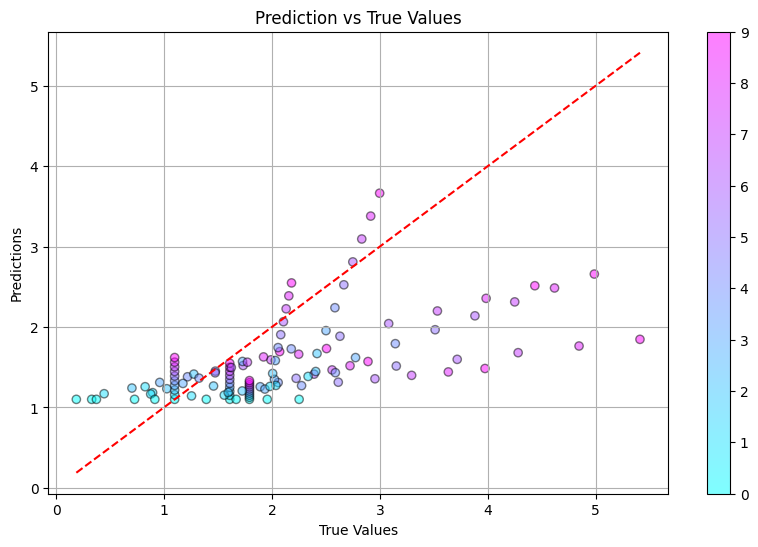

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.321e+01, tolerance: 5.481e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.616e+01, tolerance: 5.407e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.166, Best_Valid_Score: 0.111

Best_Model_Params:
{'tol': 1, 'l1_ratio': 0.6, 'alpha': 0.5}

################################################################
 


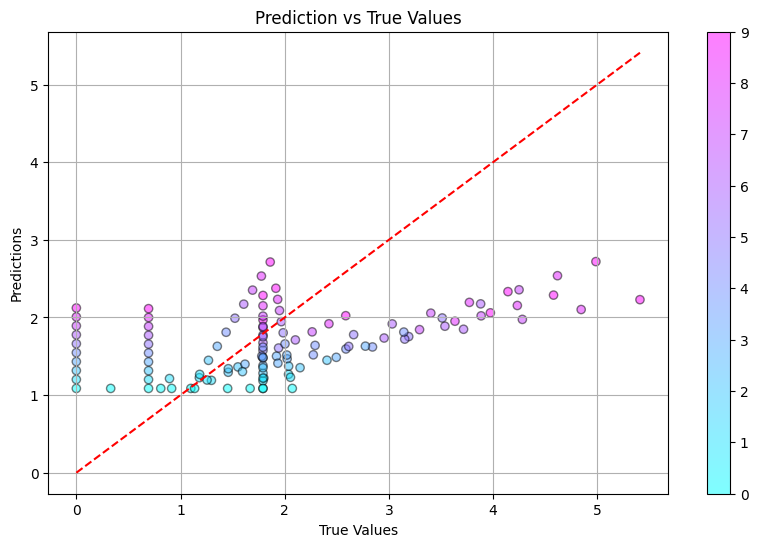

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e+02, tolerance: 5.599e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e+02, tolerance: 5.719e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: 0.117, Best_Valid_Score: 0.129

Best_Model_Params:
{'tol': 0.001, 'l1_ratio': 0, 'alpha': 100}

################################################################
 


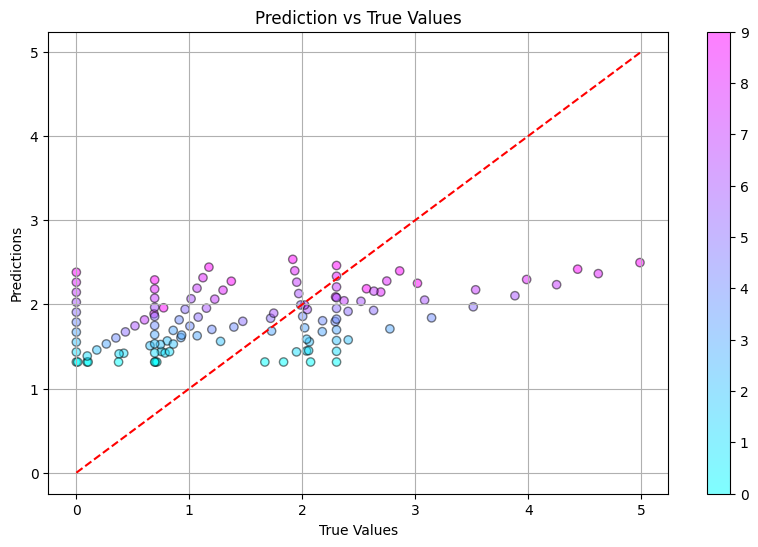

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e+01, tolerance: 5.371e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e+01, tolerance: 5.287e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.081, Best_Valid_Score: 0.104

Best_Model_Params:
{'tol': 3, 'l1_ratio': 0, 'alpha': 100}

################################################################
 


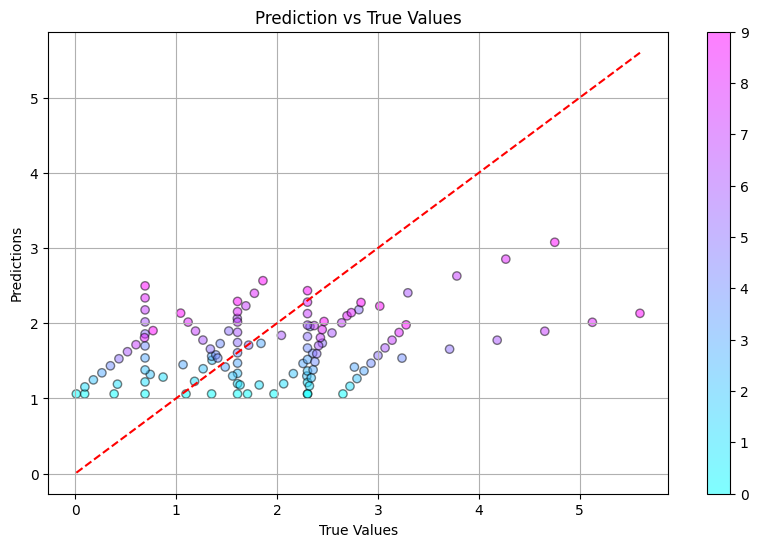

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.184e+01, tolerance: 4.402e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.172e+01, tolerance: 5.844e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.083, Best_Valid_Score: 0.021

Best_Model_Params:
{'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}

################################################################
 


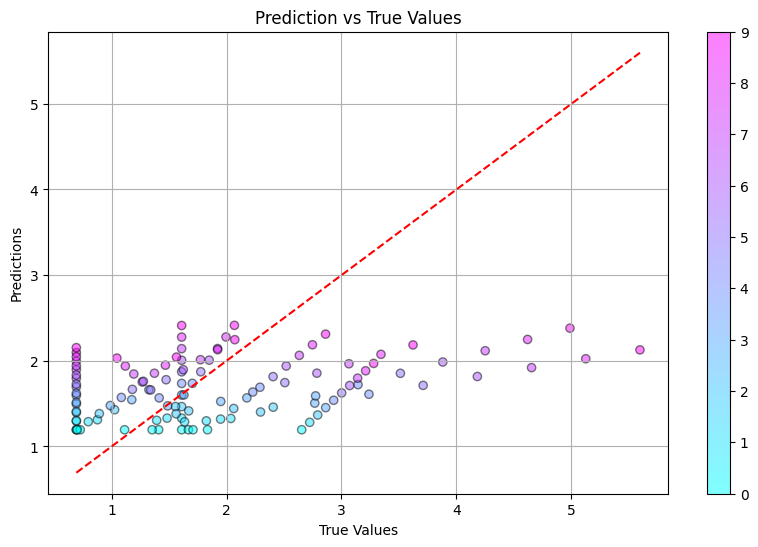

   Iter  Valid Score  Test Score                                  Model Parms  \
0     3     0.129177    0.117327  {'tol': 0.001, 'l1_ratio': 0, 'alpha': 100}   
1     1     0.075314    0.059085  {'tol': 0.1, 'l1_ratio': 0.6, 'alpha': 0.5}   
2     4     0.104074    0.080805      {'tol': 3, 'l1_ratio': 0, 'alpha': 100}   
3     2     0.110986    0.165505    {'tol': 1, 'l1_ratio': 0.6, 'alpha': 0.5}   
4     5     0.020800    0.082938    {'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}   

                                               Genes  \
0  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   
1  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   
2  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   
3  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   
4  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   

                                      True Abundance  \
0  [0.6991820674316542, 0.7518669626929761, 0.804...   
1  [0.1875793150727274, 0.4451864182509482, 0.702...   
2  [0.38

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.867e+02, tolerance: 7.418e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


,Feature,Importance
13,12,0.008091
10,9,0.007905
194,193,0.007305
385,384,0.006319
196,195,0.006192
...,...,...
155,154,0.000024
71,70,0.000015
166,165,0.000012
83,82,0.000006


,Model,Iter,Valid Score,Test Score,Model Parms,Genes,True Abundance,Predicted Abundance,Score_difference,Highest Transcript Importance
0,random_forest,3,0.038415,0.034642,"{'min_samples_split': 2, 'min_samples_leaf': 5...","[CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...","[0.6991820674316542, 0.7518669626929761, 0.804...","[1.3284832184325037, 1.3227904243766588, 1.531...",0.003773,0.007414
1,random_forest,1,0.005576,0.010578,"{'min_samples_split': 2, 'min_samples_leaf': 5...","[CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...","[0.1875793150727274, 0.4451864182509482, 0.702...","[1.3225071603736405, 1.3918632195999543, 1.539...",0.005002,0.007414
2,random_forest,5,0.008782,0.016375,"{'min_samples_split': 4, 'min_samples_leaf': 6...","[TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...","[1.609438286965999, 1.6094388663929788, 1.6094...","[1.4073101330312594, 1.4440181158696777, 1.644...",0.007593,0.007414
0,elastic_net,3,0.129177,0.117327,"{'tol': 0.001, 'l1_ratio': 0, 'alpha': 100}","[CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...","[0.6991820674316542, 0.7518669626929761, 0.804...","[1.3148521391263068, 1.440009441513493, 1.5651...",0.011850,0.003156
1,elastic_net,1,0.075314,0.059085,"{'tol': 0.1, 'l1_ratio': 0.6, 'alpha': 0.5}","[CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...","[0.1875793150727274, 0.4451864182509482, 0.702...","[1.1001305339620404, 1.1702829517086086, 1.240...",0.016228,0.003156
2,elastic_net,4,0.104074,0.080805,"{'tol': 3, 'l1_ratio': 0, 'alpha': 100}","[CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...","[0.38682625062047, 0.8718885835675858, 1.35695...","[1.0598325932028305, 1.2838993891377284, 1.507...",0.023269,0.003156
0,decision_tree,1,0.021031,-0.005500,"{'min_samples_split': 2, 'min_samples_leaf': 6...","[CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...","[0.1875793150727274, 0.4451864182509482, 0.702...","[1.2407789168241243, 1.7485040847236264, 1.748...",0.026531,0.000000
3,elastic_net,2,0.110986,0.165505,"{'tol': 1, 'l1_ratio': 0.6, 'alpha': 0.5}","[CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...","[1.452575346685607, 1.800192204848694, 2.14780...","[1.085921341411713, 1.2195020077587686, 1.3530...",0.054519,0.003156
3,random_forest,2,0.033275,0.090498,"{'min_samples_split': 2, 'min_samples_leaf': 1...","[CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...","[1.452575346685607, 1.800192204848694, 2.14780...","[1.1923276133318392, 1.2393532543004087, 1.340...",0.057223,0.007414
4,elastic_net,5,0.020800,0.082938,"{'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}","[TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...","[1.609438286965999, 1.6094388663929788, 1.6094...","[1.1949423041142127, 1.3301614601127452, 1.465...",0.062138,0.003156


In [12]:
model_names=['decision_tree', 'random_forest', 'elastic_net']

best_models=[]
CV_datasets=[]
model_transcript_imp=[]
for model_name in model_names:
    trainer = MLModelTrainer(model_name=model_name, n_iter=5, cv=5, group_by_gene=True)
    trainer.cross_validation(X,y)
    trainer.results()
    trainer.find_best_model()
    print(trainer.CV_dataset)
    print(trainer.best_model)
    best_models.append(trainer.best_model)
    importances=trainer.get_importances()
    display(importances)
    if("Transcripts" in importances["Feature"].values):
        model_transcript_imp.append(importances.loc[importances["Feature"]=="Transcripts", "Importance"].values[0])
    else:
        model_transcript_imp.append(0)
    CV_datasets.append(trainer.CV_dataset)
    trainer.CV_dataset.to_pickle("bulkcell_"+descriptors+"_"+model_name+'_Quantile'+quantile+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    with open('/kaggle/working/bulkcell_'+descriptors+'_'+model_name+'_Quantile'+quantile+'_model.pkl', 'wb') as file: # Save the Model to pickle file
              pickle.dump(trainer.best_model, file)
combined_datasets=pd.concat(CV_datasets, axis=0)
model_col=[]
transcript_imp_col=[]
for j, m in enumerate(model_names):
    for i in range(5):
        model_col.append(m)
        transcript_imp_col.append(model_transcript_imp[j])
combined_datasets.insert(0,"Model",model_col)
combined_datasets["Highest Transcript Importance"]=transcript_imp_col
combined_datasets.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True)
display(combined_datasets)
combined_datasets.to_excel("bulkcell_"+descriptors+'_Quantile'+quantile+"_grouped.xlsx")

## Non-Grouped


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: -0.135, Best_Valid_Score: 0.048

Best_Model_Params:
{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 2}

################################################################
 


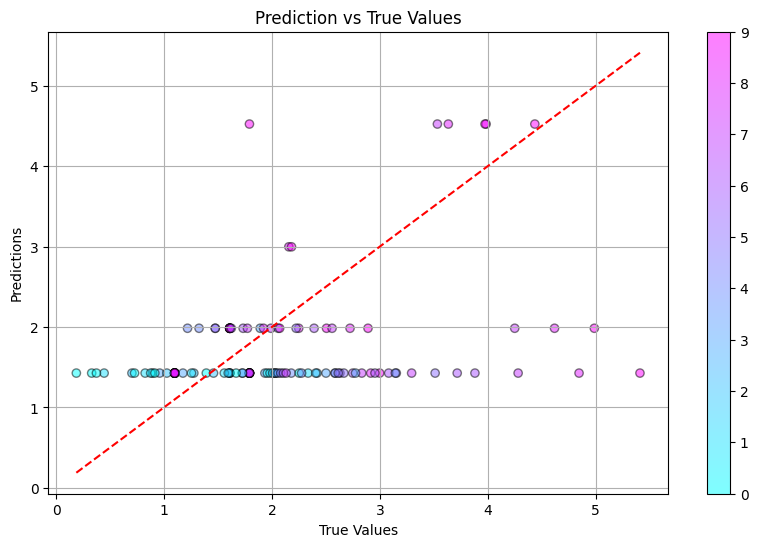


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.195, Best_Valid_Score: 0.114

Best_Model_Params:
{'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 2}

################################################################
 


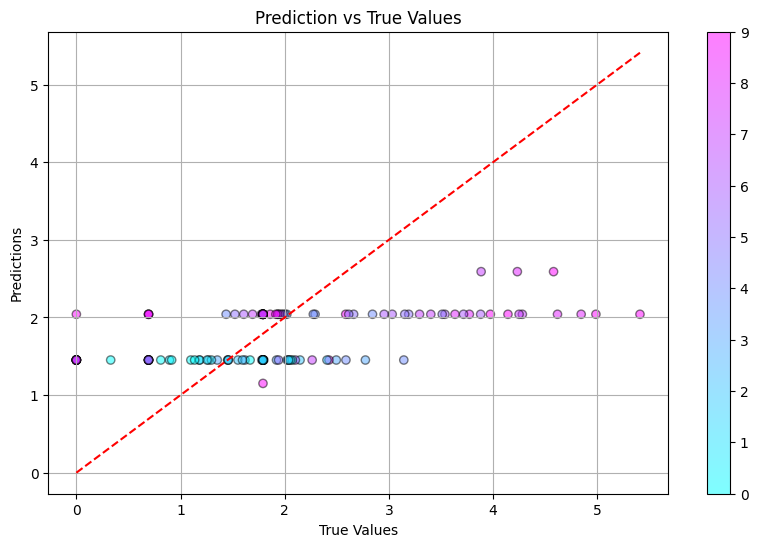


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: -0.899, Best_Valid_Score: 0.254

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 4, 'max_depth': 2}

################################################################
 


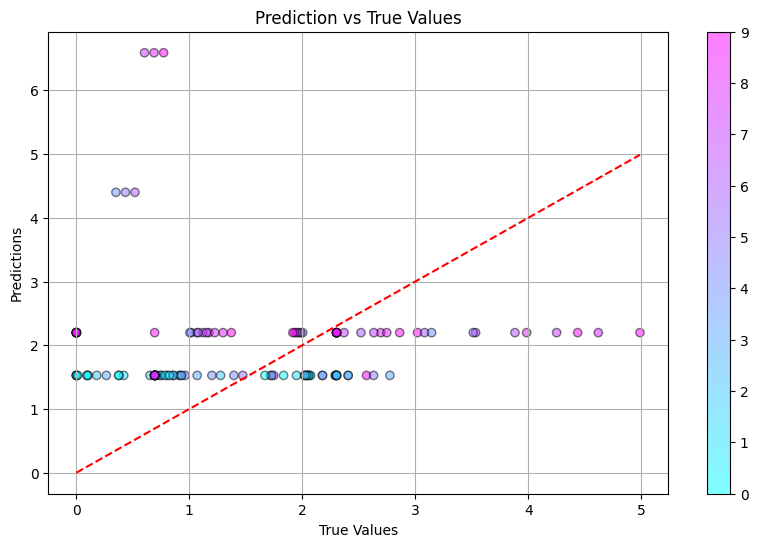


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.133, Best_Valid_Score: 0.007

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 2}

################################################################
 


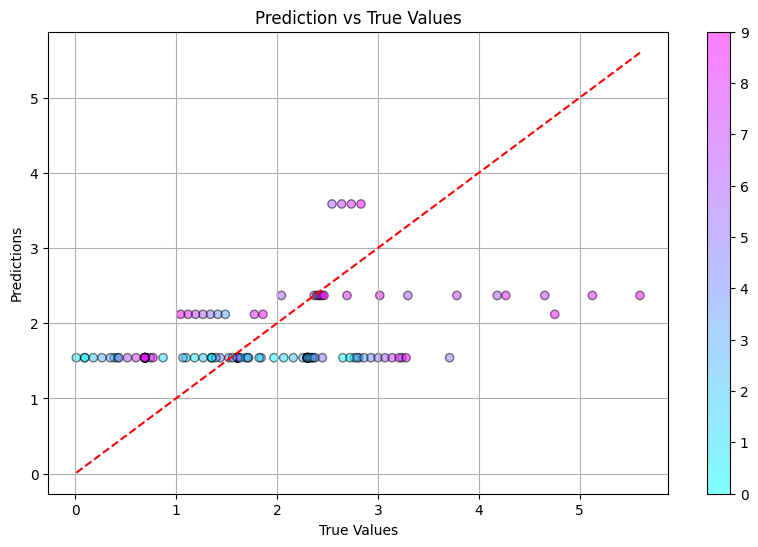


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: -0.257, Best_Valid_Score: 0.189

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 3}

################################################################
 


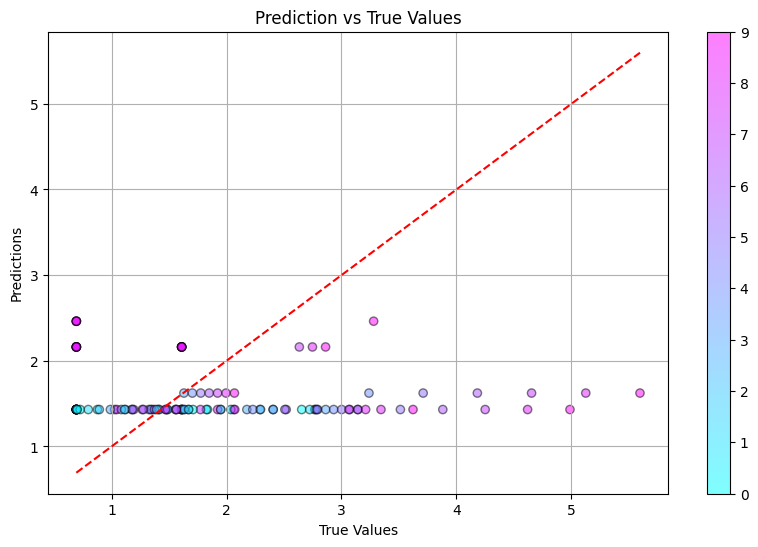

   Iter  Valid Score  Test Score  \
0     2     0.114083    0.195282   
1     4     0.006941    0.132754   
2     1     0.047959   -0.134530   
3     5     0.188907   -0.257195   
4     3     0.254386   -0.898607   

                                         Model Parms  \
0  {'min_samples_split': 3, 'min_samples_leaf': 3...   
1  {'min_samples_split': 4, 'min_samples_leaf': 2...   
2  {'min_samples_split': 3, 'min_samples_leaf': 3...   
3  {'min_samples_split': 2, 'min_samples_leaf': 4...   
4  {'min_samples_split': 4, 'min_samples_leaf': 2...   

                                               Genes  \
0  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   
1  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   
2  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   
3  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   
4  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   

                                      True Abundance  \
0  [1.452575346685607, 1.800192204848694, 2.14780... 

,Feature,Importance
235,234,0.539898
88,87,0.406593
148,147,0.053508



################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: 0.063, Best_Valid_Score: 0.009

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 2, 'max_depth': 4}

################################################################
 


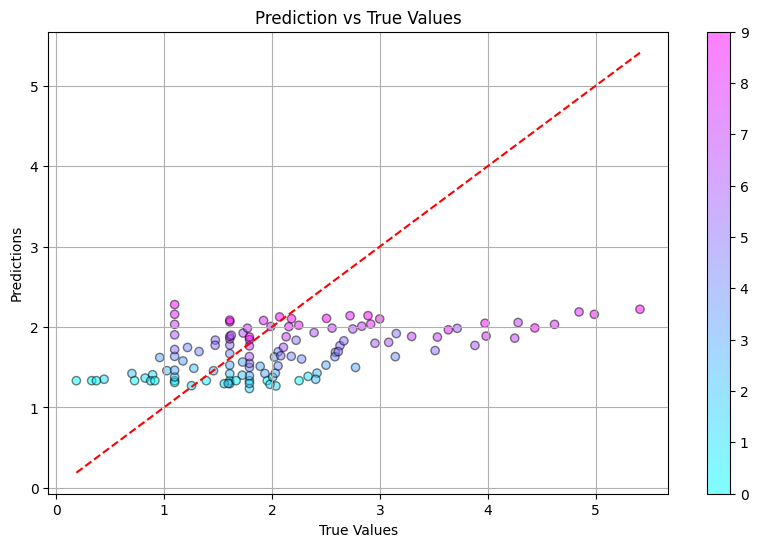


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.090, Best_Valid_Score: 0.031

Best_Model_Params:
{'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 10, 'max_depth': 3}

################################################################
 


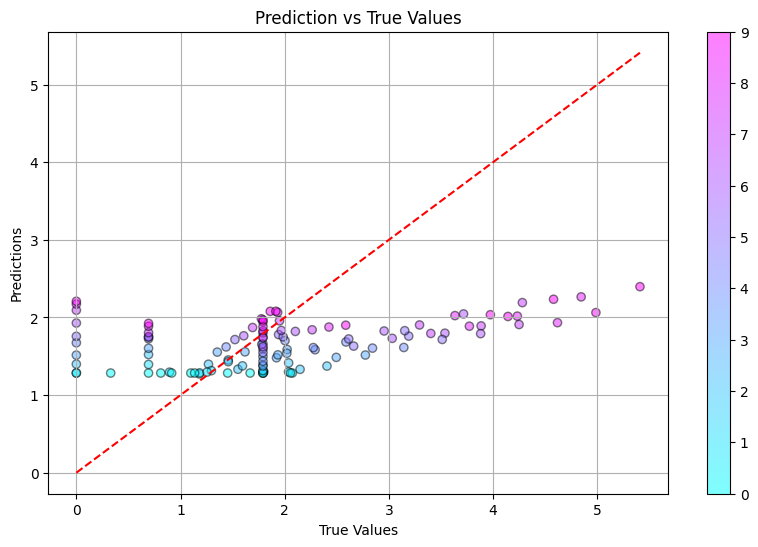


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: 0.025, Best_Valid_Score: 0.031

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 6, 'max_depth': 2}

################################################################
 


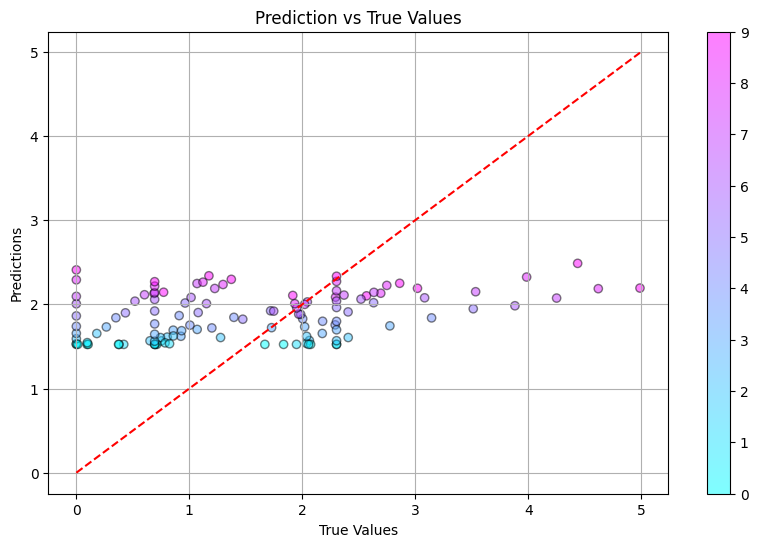


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.076, Best_Valid_Score: 0.129

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 3}

################################################################
 


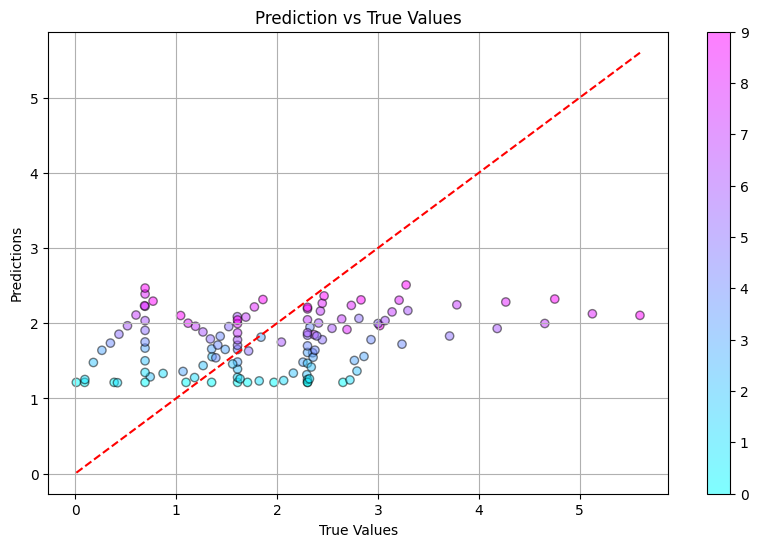


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: -0.013, Best_Valid_Score: 0.001

Best_Model_Params:
{'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 8, 'max_depth': 3}

################################################################
 


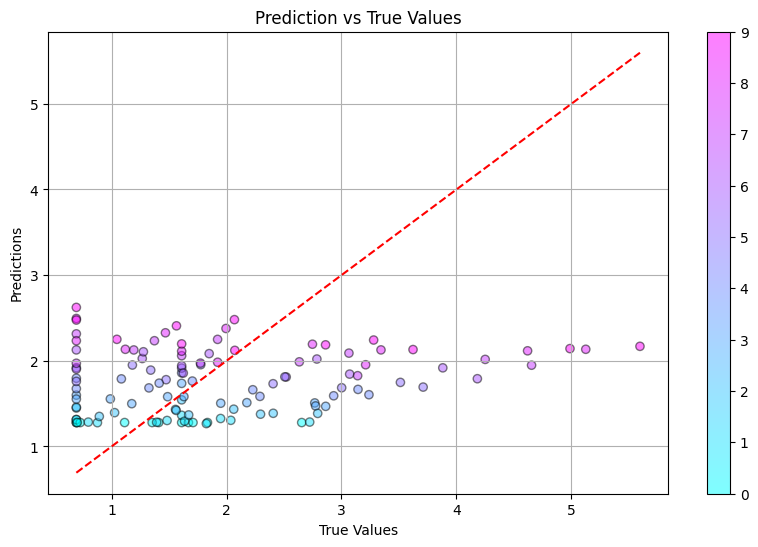

   Iter  Valid Score  Test Score  \
0     3     0.030824    0.024909   
1     5     0.000849   -0.013294   
2     4     0.128730    0.076106   
3     1     0.009093    0.063244   
4     2     0.031338    0.090045   

                                         Model Parms  \
0  {'min_samples_split': 4, 'min_samples_leaf': 3...   
1  {'min_samples_split': 4, 'min_samples_leaf': 3...   
2  {'min_samples_split': 4, 'min_samples_leaf': 1...   
3  {'min_samples_split': 4, 'min_samples_leaf': 2...   
4  {'min_samples_split': 2, 'min_samples_leaf': 3...   

                                               Genes  \
0  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   
1  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   
2  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   
3  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   
4  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   

                                      True Abundance  \
0  [0.6991820674316542, 0.7518669626929761, 0.804... 

,Feature,Importance
2,1,0.038808
64,63,0.03502
16,15,0.034894
317,316,0.026005
292,291,0.016307
...,...,...
266,265,0.000889
181,180,0.000775
226,225,0.000727
341,340,0.000632


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.846e+01, tolerance: 5.041e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.178e+01, tolerance: 5.750e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 1 of 5 runs completed
Test_Score: -0.119, Best_Valid_Score: 0.075

Best_Model_Params:
{'tol': 0.01, 'l1_ratio': 0.4, 'alpha': 0.5}

################################################################
 


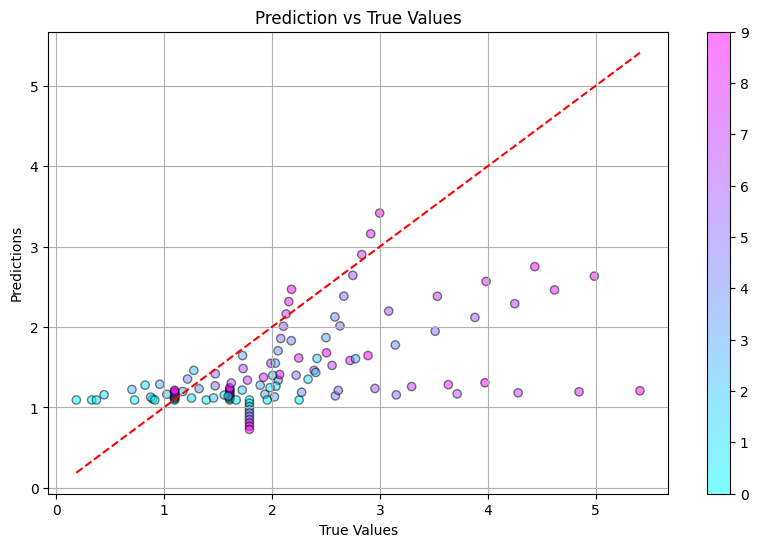

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.772e+01, tolerance: 5.481e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.677e+01, tolerance: 5.051e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 2 of 5 runs completed
Test_Score: 0.191, Best_Valid_Score: 0.096

Best_Model_Params:
{'tol': 4, 'l1_ratio': 0.4, 'alpha': 1}

################################################################
 


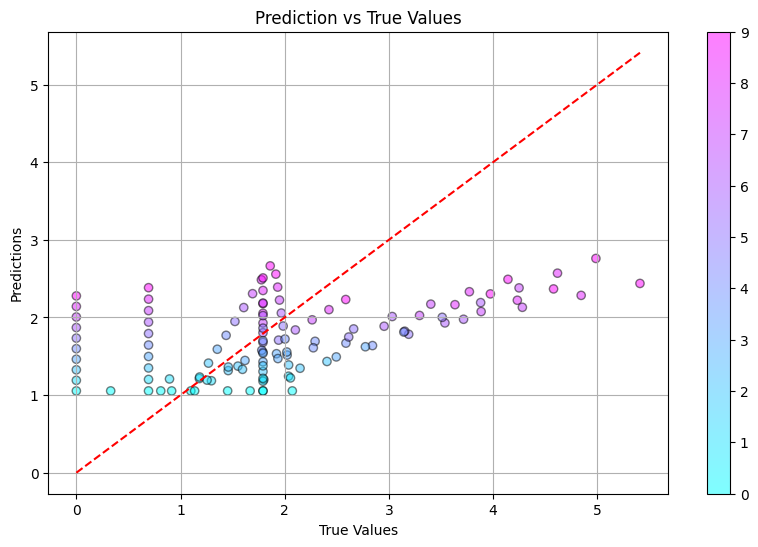

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.807e+01, tolerance: 5.719e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.872e+01, tolerance: 5.599e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 3 of 5 runs completed
Test_Score: 0.117, Best_Valid_Score: 0.129

Best_Model_Params:
{'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}

################################################################
 


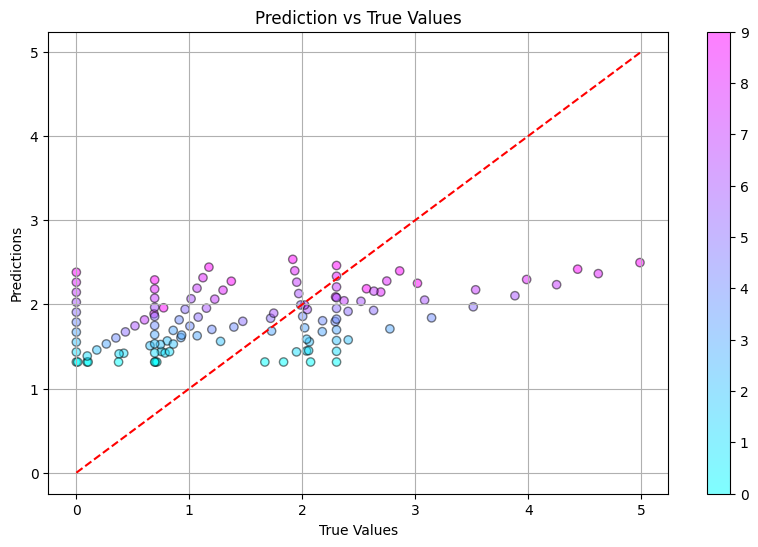

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+01, tolerance: 5.287e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.163e+01, tolerance: 4.731e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 4 of 5 runs completed
Test_Score: 0.081, Best_Valid_Score: 0.104

Best_Model_Params:
{'tol': 15, 'l1_ratio': 0, 'alpha': 100}

################################################################
 


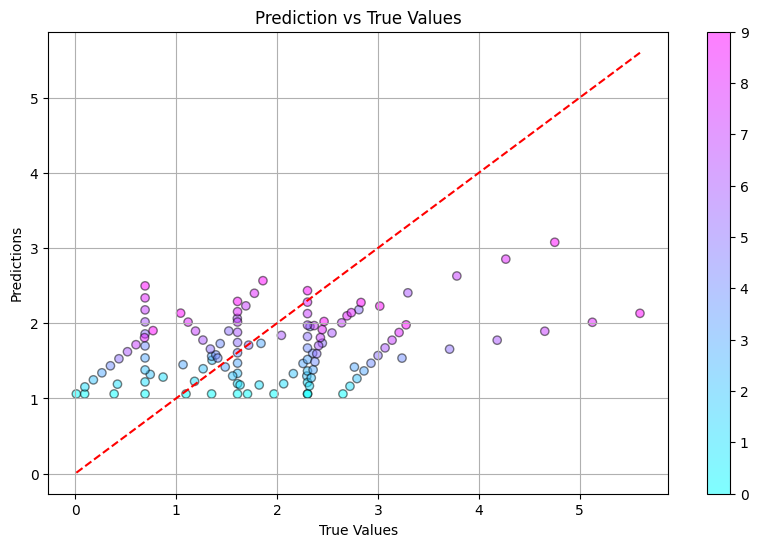

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.579e+01, tolerance: 4.402e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e+01, tolerance: 5.844e-03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode


################################################################

STATUS REPORT:
Iteration 5 of 5 runs completed
Test_Score: 0.018, Best_Valid_Score: 0.016

Best_Model_Params:
{'tol': 10, 'l1_ratio': 0, 'alpha': 50}

################################################################
 


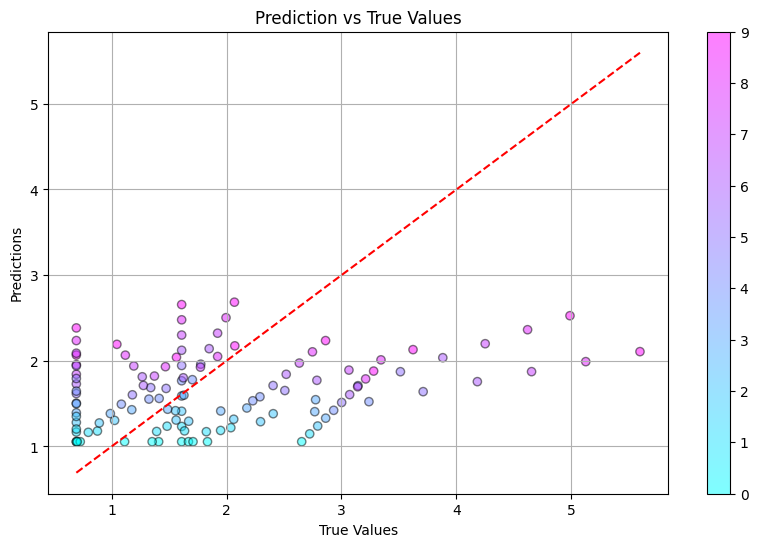

   Iter  Valid Score  Test Score  \
0     5     0.015853    0.018475   
1     3     0.129177    0.117327   
2     4     0.104074    0.080805   
3     2     0.096308    0.191158   
4     1     0.075286   -0.118924   

                                    Model Parms  \
0       {'tol': 10, 'l1_ratio': 0, 'alpha': 50}   
1     {'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}   
2      {'tol': 15, 'l1_ratio': 0, 'alpha': 100}   
3       {'tol': 4, 'l1_ratio': 0.4, 'alpha': 1}   
4  {'tol': 0.01, 'l1_ratio': 0.4, 'alpha': 0.5}   

                                               Genes  \
0  [TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...   
1  [CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...   
2  [CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...   
3  [CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...   
4  [CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...   

                                      True Abundance  \
0  [1.609438286965999, 1.6094388663929788, 1.6094...   
1  [0.6991820674316542, 0.7

,Feature,Importance
10,9,0.023556
0,Transcripts,0.022272
13,12,0.020952
1,0,0.017824
16,15,0.013474
...,...,...
191,190,0.000083
380,379,0.000079
254,253,0.000067
349,348,0.000028


,Model,Iter,Valid Score,Test Score,Model Parms,Genes,True Abundance,Predicted Abundance,Score_difference,Highest Transcript Importance
0,elastic_net,5,0.015853,0.018475,"{'tol': 10, 'l1_ratio': 0, 'alpha': 50}","[TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...","[1.609438286965999, 1.6094388663929788, 1.6094...","[1.0553545293841071, 1.2332355182990058, 1.411...",0.002622,0.022272
0,random_forest,3,0.030824,0.024909,"{'min_samples_split': 4, 'min_samples_leaf': 3...","[CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...","[0.6991820674316542, 0.7518669626929761, 0.804...","[1.5242017182278251, 1.5658215441881567, 1.610...",0.005915,0.008229
1,elastic_net,3,0.129177,0.117327,"{'tol': 0.1, 'l1_ratio': 0, 'alpha': 100}","[CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR4, CCR...","[0.6991820674316542, 0.7518669626929761, 0.804...","[1.3148521391263068, 1.440009441513493, 1.5651...",0.011850,0.022272
1,random_forest,5,0.000849,-0.013294,"{'min_samples_split': 4, 'min_samples_leaf': 3...","[TNFRSF18, TNFRSF18, TNFRSF18, TNFRSF18, TNFRS...","[1.609438286965999, 1.6094388663929788, 1.6094...","[1.278970795175053, 1.3639149609288679, 1.5441...",0.014143,0.008229
2,elastic_net,4,0.104074,0.080805,"{'tol': 15, 'l1_ratio': 0, 'alpha': 100}","[CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...","[0.38682625062047, 0.8718885835675858, 1.35695...","[1.0598325932028305, 1.2838993891377284, 1.507...",0.023269,0.022272
2,random_forest,4,0.128730,0.076106,"{'min_samples_split': 4, 'min_samples_leaf': 1...","[CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, CD7, ...","[0.38682625062047, 0.8718885835675858, 1.35695...","[1.2135472167119743, 1.332220223030834, 1.5547...",0.052625,0.008229
3,random_forest,1,0.009093,0.063244,"{'min_samples_split': 4, 'min_samples_leaf': 2...","[CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3D, CD3...","[0.1875793150727274, 0.4451864182509482, 0.702...","[1.3324973174490318, 1.3498632252370977, 1.420...",0.054151,0.008229
4,random_forest,2,0.031338,0.090045,"{'min_samples_split': 2, 'min_samples_leaf': 3...","[CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...","[1.452575346685607, 1.800192204848694, 2.14780...","[1.2843613488027776, 1.3008033041899842, 1.331...",0.058707,0.008229
0,decision_tree,2,0.114083,0.195282,"{'min_samples_split': 3, 'min_samples_leaf': 3...","[CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...","[1.452575346685607, 1.800192204848694, 2.14780...","[1.4519195394570443, 1.4519195394570443, 1.451...",0.081199,0.000000
3,elastic_net,2,0.096308,0.191158,"{'tol': 4, 'l1_ratio': 0.4, 'alpha': 1}","[CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, CR1, ...","[1.452575346685607, 1.800192204848694, 2.14780...","[1.0540386720649044, 1.2000146267041354, 1.345...",0.094851,0.022272


In [13]:
model_names=['decision_tree', 'random_forest', 'elastic_net']

best_models=[]
CV_datasets=[]
model_transcript_imp=[]
for model_name in model_names:
    trainer = MLModelTrainer(model_name=model_name, n_iter=5, cv=5, group_by_gene=True)
    trainer.cross_validation(X,y)
    trainer.results()
    trainer.find_best_model()
    print(trainer.CV_dataset)
    print(trainer.best_model)
    best_models.append(trainer.best_model)
    importances=trainer.get_importances()
    display(importances)
    if("Transcripts" in importances["Feature"].values):
        model_transcript_imp.append(importances.loc[importances["Feature"]=="Transcripts", "Importance"].values[0])
    else:
        model_transcript_imp.append(0)
    CV_datasets.append(trainer.CV_dataset)
    trainer.CV_dataset.to_pickle("bulkcell_"+descriptors+"_"+model_name+'_Quantile'+quantile+".pkl", compression='infer', protocol=5, storage_options=None) # save dataframe as pickle file
    with open('/kaggle/working/bulkcell_'+descriptors+'_'+model_name+'_Quantile'+quantile+'_model.pkl', 'wb') as file: # Save the Model to pickle file
              pickle.dump(trainer.best_model, file)
combined_datasets=pd.concat(CV_datasets, axis=0)
model_col=[]
transcript_imp_col=[]
for j, m in enumerate(model_names):
    for i in range(5):
        model_col.append(m)
        transcript_imp_col.append(model_transcript_imp[j])
combined_datasets.insert(0,"Model",model_col)
combined_datasets["Highest Transcript Importance"]=transcript_imp_col
combined_datasets.sort_values(by=['Score_difference', 'Test Score'], ascending=[True, False], inplace=True)
display(combined_datasets)
combined_datasets.to_excel("bulkcell_"+descriptors+'_Quantile'+quantile+"_ungrouped.xlsx")

In [14]:
y

,Proteins
0,0.055513
1,0.246011
2,0.436509
3,0.627007
4,0.817504
...,...
575,1.985491
576,1.967953
577,1.950415
578,1.932877


In [15]:
'''predictors=["12", "5"]

plt.scatter(X["8"], X["18"], alpha=0.3, c=y.values)
plt.title("Effect of predictors "+str(predictors)+" on quantile "+quantile)
plt.xlabel("Predictor "+predictors[0])
plt.ylabel("Predictor "+predictors[1])
plt.colorbar()
plt.show()'''

'predictors=["12", "5"]\n\nplt.scatter(X["8"], X["18"], alpha=0.3, c=y.values)\nplt.title("Effect of predictors "+str(predictors)+" on quantile "+quantile)\nplt.xlabel("Predictor "+predictors[0])\nplt.ylabel("Predictor "+predictors[1])\nplt.colorbar()\nplt.show()'